(getting-started:tutorial-sensitivity)=
# Tutorial: Test a Sensitivity Analysis Method

UQTestFuns includes a wide range of test functions from the literature
employed in a sensitivity analysis exercise.
In this tutorial, you'll implement a sensitivity analysis method and test
the implemented method using a test function available in UQTestFuns
(the popular Ishigami function).
Afterward, you'll compare the results against analytical results.

By the end of this tutorial, you'll get an idea how a function from UQTestFuns
is used to test a sensitivity analysis method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uqtestfuns as uqtf

## Global sensitivity analysis

Sensitivity analysis is a model inference technique whose overarching goal is
to understand the inputs/outputs relationship of a complex
(potentially, black box) model. Specific goals include:

- _identification of inputs that drive output variability_ that leads to
  _factor prioritization_, that is, identifying which inputs that result in
  the largest reduction in the output variability.
- _identification of non-influential inputs_ that leads to _factor fixing_,
  that is, identifying which inputs that can be fixed at any value without
  affecting the output.

A _global_ sensitivity analysis is often distinguished from a _local_ analysis.
A local analysis is concerned with the effects
of perturbation around a particular instance of the inputs
(e.g., their nominal values) on the output.
A global analysis, on the other hand, is concerned with the effects of
variations over all possible instances of inputs 
within their respective uncertainty range on the output.

### Variance decomposition

Consider an $M$-dimensional mathematical function
$\mathcal{M}: \mathcal{D}_{\boldsymbol{X}} \in [0, 1]^M \mapsto \mathbb{R}$ that represents
a computational model of interest.

Due to uncertain inputs, represented as an $M$-dimensional random vector $\boldsymbol{X}$,
the output of the model becomes a random variable $Y = \mathcal{M}(\boldsymbol{X})$.
It is further assumed that the components $X_m$'s of the random vector $\boldsymbol{X}$
are mutually independent such that the joint probability density function $f_{\boldsymbol{X}}$
reads:

$$
f_{\boldsymbol{X}}(\boldsymbol{x}) = \prod_{m = 1}^M f_{X_m}(x_m),
$$

where $f_{X_m}$ is the marginal probability density function of $X_m$.

The Hoeffding-Sobol' variance decomposition of random variable $Y$ reads as follows:

$$
\mathbb{V}[Y] = \sum_{m = 1}^M V_i + \sum_{1 \leq i < j \leq M} V_{m, n} + \ldots + V_{1, \ldots, M},
$$

where the terms are partial variances defined below:

- $V_m = \mathbb{V}_{X_m} \left[ \mathbb{E}_{X_{\sim m}}\left[ Y | X_m \right]\right]$
- $V_{m, n} = \mathbb{V}_{X_{\{m, n\}}} \left[ \mathbb{E}_{X_{\sim \{m, n\}}}\left[ Y | X_m, X_n \right]\right]$
- etc.

### Sobol' sensitivity indices

By normalizing the above equation with the total variance $\mathbb{V}[Y]$, we obtain the following expression:

$$
1 = \sum_{m = 1}^M S_m + \sum_{1 \leq m < n \leq M} S_{m, n} + \ldots + S_{1, \ldots, M},
$$

where now each term is a normalized partial variance.
These normalized terms are called Sobol' sensitivity indices and there are $2^M - 1$ (where $M$ is the number of dimension)
indices.

Of particular importance is the _first-order_ (or _main-effect_) Sobol' index $S_m$ defined as follows {cite}`Sobol1993`:

$$
S_m = \frac{\mathbb{V}_{X_m} \left[ \mathbb{E}_{X_{\sim m}}\left[ Y | \boldsymbol{X}_m \right]\right]}{\mathbb{V}[Y]}.
$$

This index indicates the importance of a particular input variable on the output variance. These indices are aligned
with the aforementioned _factor prioritization_ goal of sensitivity analysis.

Another sensitivity index of particular importance is the _total-effect_ Sobol' index defined for input variable $m$
below {cite}`Homma1996`:

$$
ST_m = 1 - \frac{\mathbb{V}_{\boldsymbol{X}_{\sim m}}[\mathbb{E}_{X_m}[Y | \boldsymbol{X}_{\sim m}]]}{\mathbb{V}[Y]}.
$$

### Monte-Carlo estimation

```{warning}
A method to estimate the main-effect and total-effect indices via
a Monte-Carlo simulation is implemented here following the most
naive and straightforward approach.
It is only to serve as an illustration.
This implementation is, however, not the state-of-the-art approach to estimate
the indices (see, for instance, {cite}`Saltelli2002, Saltelli2010`).
Please refer to a dedicated sensitivity analysis and uncertainty
quantification package for a proper analysis.
```

The estimation of the Sobol' sensitivity indices as defined
in the above equations can be directly carried out using
a Monte-Carlo simulation.
The most straightforward, though rather naive and computationally expensive,
method is to use a nested loop for the 
computation of the conditional variances and expectations appearing
in both indices.

For instance, in the estimation of the first-order index of, say,
input variable $x_m$, the outer loop samples values of $X_m$
while the inner loop samples values of $\boldsymbol{X}_{\sim m}$
(i.e., all input variables except $x_m$).
The cost of the analysis in terms of the model evaluations for estimating
the first-order index for _each input variable_ is $N^2$ where $N$
is the Monte-Carlo sample size.
It is expected that size of $N$ is between $10^3$ and $10^6$.

{prf:ref}`Brute Force MC First-Order` below illustrates
the procedure to compute main-effect Sobol' indices.

```{prf:algorithm} Brute force MC for estimating all $S_m$
:label: Brute Force MC First-Order

**Inputs** A computational model $\mathcal{M}$, random input variables $\boldsymbol{X} = \{ X_1, \ldots, X_M \}$, number of MC sample points $N$

**Output** First-order Sobol' sensitivity indices $S_m$ for $m = 1, \ldots, M$

For $m = 1$ to $M$:

1. $\Sigma_i \leftarrow 0$
2. $\Sigma_i^2 \leftarrow 0$
3. For $i = 1$ to $N$:

   1. Sample $x_m^{(i)}$ from $X_m$
   2. $\Sigma_j \leftarrow 0$
   3. For $j = 1$ to $N$:
  
      1. Sample $\boldsymbol{x}_{\sim m}^{(j)}$ from $\boldsymbol{X}_{\sim m}$
      2. $\Sigma_j \leftarrow \Sigma_j + \mathcal{M}(x_m^{(j)}, \boldsymbol{x}_{\sim m}^{(j)})$
    
   4. $\mathbb{E}_{\boldsymbol{X}_{\sim m}}\left[ Y | X_m \right]^{(i)} \leftarrow \frac{1}{N} \Sigma_j$
   5. $\Sigma_i \leftarrow \Sigma_i + \mathbb{E}_{\boldsymbol{X}_{\sim m}}\left[ Y | X_m \right]^{(i)}$
   6. $\Sigma_{i^2} \leftarrow \Sigma_{i^2} + \left( \mathbb{E}_{\boldsymbol{X}_{\sim m}}\left[ Y | X_m \right]^{(i)} \right)^2$
4. $\mathbb{V}_{X_m} \left[ \mathbb{E}_{\boldsymbol{X}_{\sim m}}\left[ Y | X_m \right]\right] \leftarrow \frac{1}{N} \Sigma_{i^2} - 
\left( \frac{1}{N} \Sigma_{i} \right)^2$
5. $S_m \leftarrow \frac{\mathbb{V}_{X_m} \left[ \mathbb{E}_{\boldsymbol{X}_{\sim m}}\left[ Y | X_m \right]\right]}{\mathbb{V}[Y]}$
```

The output variance $\mathbb{V}[Y]$ used in the above algorithm can be computed following {prf:ref}`Brute Force Output Variance`.

```{prf:algorithm} Brute force MC for estimating output variance $\mathbb{V}[Y]$
:label: Brute Force Output Variance

**Inputs** A computational model $\mathcal{M}$, random input variables $\boldsymbol{X}$, number of MC sample points $N$

**Output** Output variance $\mathbb{V}[Y]$

1. $\Sigma_i \leftarrow 0$
2. $\Sigma_i^2 \leftarrow 0$
3. For $i = 1$ to $N$:

   1. Sample $\boldsymbol{x}^{(i)}$ from $\boldsymbol{X}$
   2. $\Sigma_i \leftarrow \Sigma_i + \mathcal{M}(\boldsymbol{x}^{(i)})$
   3. $\Sigma_{i^2} \leftarrow \Sigma_{i^2} + \left( \mathcal{M}(\boldsymbol{x}^{(i)} \right)^2$
    
4. $\mathbb{V}[Y] \leftarrow \frac{1}{N} \Sigma_{i^2} - \left( \frac{1}{N} \Sigma_i \right)^2$
```

Similar Monte-Carlo algorithm can be devised to compute
the total-effect Sobol' indices
as shown in {prf:ref}`Brute Force MC Total-Effect`.

```{prf:algorithm} Brute force MC for estimating all $ST_m$
:label: Brute Force MC Total-Effect

**Inputs** A computational model $\mathcal{M}$, random input variables $\boldsymbol{X} = \{ X_1, \ldots, X_M \}$, number of MC sample points $N$

**Output** First-order Sobol' sensitivity indices $S_m$ for $m = 1, \ldots, M$

For $m = 1$ to $M$:

1. $\Sigma_i \leftarrow 0$
2. $\Sigma_i^2 \leftarrow 0$
3. For $i = 1$ to $N$:

   1. Sample $\boldsymbol{x}_{\sim m}^{(i)}$ from $\boldsymbol{X}_{\sim m}$
   2. $\Sigma_j \leftarrow 0$
   3. For $j = 1$ to $N$:
  
      1. Sample $x_{m}^{(j)}$ from $X_m$
      2. $\Sigma_j \leftarrow \Sigma_j + \mathcal{M}(x_m^{(j)}, \boldsymbol{x}_{\sim m}^{(j)})$
    
   4. $\mathbb{E}_{X_m}\left[ Y | \boldsymbol{X}_{\sim m} \right]^{(i)} \leftarrow \frac{1}{N} \Sigma_j$
   5. $\Sigma_i \leftarrow \Sigma_i + \mathbb{E}_{X_m}\left[ Y | \boldsymbol{X}_{\sim m} \right]^{(i)}$
   6. $\Sigma_{i^2} \leftarrow \Sigma_{i^2} + \left( \mathbb{E}_{X_m}\left[ Y | \boldsymbol{X}_{\sim m} \right]^{(i)} \right)^2$
4. $\mathbb{V}_{\boldsymbol{X}_{\sim m}} \left[ \mathbb{E}_{X_m}\left[ Y | \boldsymbol{X}_{\sim m} \right]\right] \leftarrow \frac{1}{N} \Sigma_{i^2} - 
\left( \frac{1}{N} \Sigma_{i} \right)^2$
5. $ST_m \leftarrow 1 - \frac{\mathbb{V}_{\boldsymbol{X}_{\sim m}} \left[ \mathbb{E}_{X_m}\left[ Y | \boldsymbol{X}_{\sim m} \right]\right]}{\mathbb{V}[Y]}$
```

These algorithms are implemented in a Python function that returns
the main-effect and total-effect Sobol' indices
of all the input variables of a computational model.
The function assumes that a probabilistic input model of the computational
model has been defined such that sample points may be generated from them.

```{note}
And indeed, test functions included in UQTestFuns are all given with the
corresponding probabilistic input model according to the literature.
```

In [2]:
def estimate_sobol_indices(my_func, prob_input, num_sample):
    """Estimate the first-order and total-effect Sobol' indices via MC.
    
    Parameters
    ----------
    my_func
        The function (or computational model) to analyze.
    prob_input
        The probabilistic input model of the function.
    num_sample
        The Monte-Carlo sample size.
       
    Returns
    -------
    A tuple of NumPy array: first-order and total-effect Sobol' indices each
    has a length of the number of input variables.
    """

    # --- Compute output variance
    xx = prob_input.get_sample(num_sample)
    yy = my_func(xx)
    var_yy = np.var(yy)

    num_dim = prob_input.spatial_dimension

    # --- Compute first-order Sobol' indices
    first_order = np.zeros(num_dim)
    for m in range(num_dim):
        xx_m = prob_input.marginals[m].get_sample(num_sample)
        exp_nm = np.zeros(num_sample)
        for i in range(num_sample):
            xx = prob_input.get_sample(num_sample)
            # Replace the m-th column
            xx[:, m] = xx_m[i]
            yy = my_func(xx)
            exp_nm[i] = np.mean(yy)
        var_m = np.var(exp_nm)
        first_order[m] = var_m / var_yy

    # --- Compute total-effect Sobol' indices
    total_effect = np.zeros(num_dim)
    for m in range(num_dim):
        xx = prob_input.get_sample(num_sample)
        exp_m = np.zeros(num_sample)
        for i in range(num_sample):
            xx_m = np.repeat(xx[i:i+1], num_sample, axis=0)
            xx_m[:, m] = prob_input.marginals[m].get_sample(num_sample)
            yy = my_func(xx_m)
            exp_m[i] = np.mean(yy)
        var_nm = np.var(exp_m)
        total_effect[m] = 1 - var_nm / var_yy
    
    return first_order, total_effect

## Ishigami function

To test the implemented algorithm above,
we choose the popular Ishigami function {cite}`Ishigami1991` whose
analytical values for the sensitivity indices are known.
The function is highly non-linear and non-monotonous and given as follows:

$$
\mathcal{M}(\boldsymbol{x}) = \sin(x_1) + a \sin^2(x_2) + b \, x_3^4 \sin(x_1)
$$
where $\boldsymbol{x} = \{ x_1, x_2, x_3 \}$ is the three-dimensional vector of
input variables further defined in the table below,
and $a$ and $b$ are parameters of the function.

To create an instance of the Ishigami function:

In [3]:
ishigami = uqtf.Ishigami()

The input variables of the function are probabilistically defined according
to the table below.

In [4]:
ishigami.prob_input

ProbInput(spatial_dimension=3, marginals=(UnivDist(distribution='uniform', parameters=array([-3.14159265,  3.14159265]), name='X1', description='None'), UnivDist(distribution='uniform', parameters=array([-3.14159265,  3.14159265]), name='X2', description='None'), UnivDist(distribution='uniform', parameters=array([-3.14159265,  3.14159265]), name='X3', description='None')), copulas=None, name='Ishigami1991', description='Probabilistic input model for the Ishigami function from Ishigami and Homma (1991).')

Finally, the default values for the parameters $a$ and $b$ are:

In [5]:
ishigami.parameters

(7, 0.05)

For reproducibility of this tutorial, set the seed number for the pseudo-random
generator attached to the probabilistic input model:

In [6]:
ishigami.prob_input.reset_rng(452397)

The variance of the Ishigami function can be analytically derived
and it is a function of the parameters:

$$
\mathbb{V}[Y] = \frac{a^2}{8} + \frac{b \pi^4}{5} + \frac{b^2 \pi^8}{18} + \frac{1}{2}.
$$

The analytical sensitivity indices are also available as shown in the table
below also as functions of the parameters.

| Input variable  |                              $S_m$                              |                                                   $ST_m$                                                    |
|:---------------:|:---------------------------------------------------------------:|:-----------------------------------------------------------------------------------------------------------:|
|       $1$       | $\frac{1}{\mathbb{V}[Y]} \frac{1}{2} (1 + \frac{b \pi^4}{5})^2$ | $\frac{1}{\mathbb{V}[Y]} \left( \frac{1}{2} \, (1 + \frac{b \pi^4}{5})^2 + \frac{8 b^2 \pi^8}{225} \right)$ |
|       $2$       |             $\frac{1}{\mathbb{V}[Y]} \frac{a^2}{8}$             |                                        $\frac{a^2}{8 \mathbb{V}[Y]}$                                        | 
|       $3$       |                              $0.0$                              |                                   $\frac{8 b^2 \pi^8}{225 \mathbb{V}[Y]}$                                   | 
 
Notice that while $X_3$ does not directly influence the output variance
by itself (it's main-effect index is zero),
it does influence the output variance via interaction with $X_1$.
Furthermore, $X_2$ has no interaction effect whatsoever
as its main-effect and total-effect indices are the same.

For later comparison, we define a Python function that returns
the analytical values of the Sobol' indices of the Ishigami function.

In [7]:
def compute_sobol_indices(a, b):
    """Compute the analytical Sobol' indices for the Ishigami function."""

    # --- Compute the variance
    var_y = a**2 / 8 + b * np.pi**4 / 5 + b**2 * np.pi**8 / 18 + 1 / 2
    
    # --- Compute the first-order Sobol' indices
    first_order = np.zeros(3)
    first_order[0] = (1 + b * np.pi**4 / 5)**2 / 2
    first_order[1] = a**2 / 8
    first_order[2] = 0
    
    # --- Compute the total-effect Sobol' indices
    total_effect = np.zeros(3)
    total_effect[2] = 8 * b**2 * np.pi**8 / 225
    total_effect[1] = first_order[1]
    total_effect[0] = first_order[0] + total_effect[2] 

    return first_order / var_y, total_effect / var_y

## Sobol' indices estimation

To observe the convergence of the estimation procedure implemented above,
several Monte-Carlo sample sizes are used:

In [8]:
sample_sizes = np.arange(0, 3500, 500)[1:]
first_order_indices = np.zeros((len(sample_sizes), ishigami.spatial_dimension))
total_effect_indices = np.zeros((len(sample_sizes), ishigami.spatial_dimension))

for i, sample_size in enumerate(sample_sizes):
  first_order_indices[i, :], total_effect_indices[i, :] = estimate_sobol_indices(
      ishigami, ishigami.prob_input, sample_size
  )

Compute the analytical values for the given parameters:

In [9]:
first_order_ref, total_effect_ref = compute_sobol_indices(*ishigami.parameters)

The estimated indices as a function of sample size is plotted below;
the estimated values are in solid lines while the analytical values are in
dashed lines.

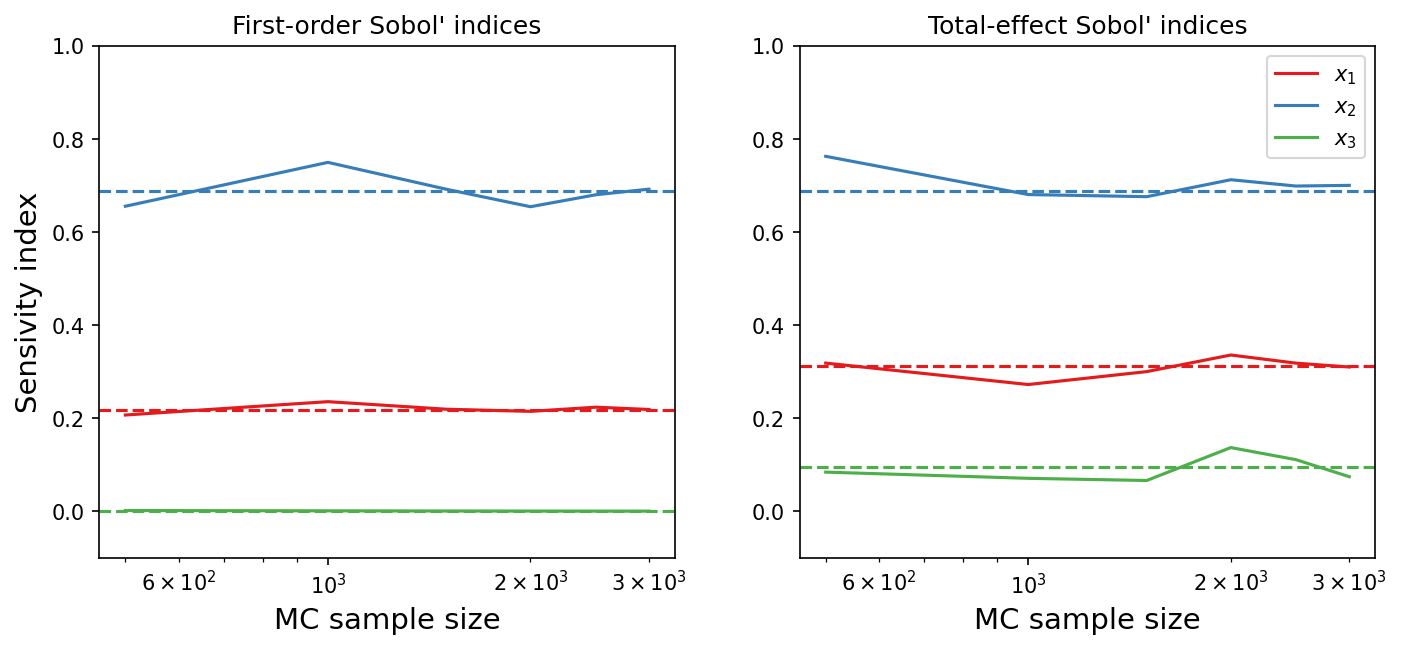

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(sample_sizes, first_order_indices[:, 0], color="#e41a1c")
axs[0].plot(sample_sizes, first_order_indices[:, 1], color="#377eb8")
axs[0].plot(sample_sizes, first_order_indices[:, 2], color="#4daf4a")

axs[0].axhline(first_order_ref[0], linestyle="--", color="#e41a1c")
axs[0].axhline(first_order_ref[1], linestyle="--", color="#377eb8")
axs[0].axhline(first_order_ref[2], linestyle="--", color="#4daf4a")

axs[0].set_xscale("log")
axs[0].set_ylim([-0.1, 1])
axs[0].set_title("First-order Sobol' indices")
axs[0].set_xlabel("MC sample size", fontsize=14)
axs[0].set_ylabel("Sensivity index", fontsize=14)

axs[1].plot(sample_sizes, total_effect_indices[:, 0], color="#e41a1c", label=r"$x_1$")
axs[1].plot(sample_sizes, total_effect_indices[:, 1], color="#377eb8", label=r"$x_2$")
axs[1].plot(sample_sizes, total_effect_indices[:, 2], color="#4daf4a", label=r"$x_3$")

axs[1].axhline(total_effect_ref[0], linestyle="--", color="#e41a1c")
axs[1].axhline(total_effect_ref[1], linestyle="--", color="#377eb8")
axs[1].axhline(total_effect_ref[2], linestyle="--", color="#4daf4a")

axs[1].set_xscale("log")
axs[1].set_ylim([-0.1, 1])
axs[1].set_title("Total-effect Sobol' indices")
axs[1].set_xlabel("MC sample size", fontsize=14)
axs[1].legend()

fig.tight_layout(pad=3.0)
plt.gcf().set_dpi(150);

The implemented method seems to estimate the indices relatively well;
increasing the Monte-Carlo sample size would improve the accuracy of
the estimates but with a high computational cost.

The challenge for a sensitivity analysis method is to ascertain the importance
(or non-importance) of input variables either qualitatively or quantitatively
with as few computational model evaluations as possible.

## References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```